# TLS Rotating frame

In [1]:
import numpy as np
from qocag import grape_schroedinger_discrete
from qocag import TargetStateInfidelity,Robustness
from qocag import ControlVariation,generate_save_file_path,ControlBandwidthMax
from qocag import LBFGSB,Adam
total_time_steps=10
#Toltal number of descretized time pieces
target_states=np.array( [0,1])
#Target state is |1>
cost1=TargetStateInfidelity(target_states=target_states)
cost2=Robustness(robust_operator=np.array([[-1,0],[0,1]]),delta=1e-7,cost_multiplier=0.5)
costs=[cost1,cost2]
total_time=10
#Evolution time is 10 ns
H0=np.array([[-1,0],[0,1]])*2*np.pi/2
H0=0
#Qubit frequency is 1GHZ
H_controls=[np.array([[0,1],[1,0]])]
#Control Hamiltonian is sigma_x
initial_states=np.array([1,0])
#Initial state is |0>
# result=np.load("./out/00000_qubit01.npy",allow_pickle=True).item()
# initial_control=result["control_iter"][-1]
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
initial_control=(np.pi/2/total_time)*np.array([np.cos(2*np.pi*times)])/np.array([np.cos(2*np.pi*times)])
result1=grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1000,
                                optimizer=Adam(),initial_controls=initial_control,mode="AD")

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  1    | 1.01418873e-06 |  8.88178420e-16  |  1.01418873e-06  |  2.15152142e-06  
  2    | 6.94722372e-06 |  3.92630687e-06  |  3.02091685e-06  |  1.25291284e-02  
  3    | 3.48622635e-05 |  2.98040874e-05  |  5.05817610e-06  |  3.45318496e-02  
  4    | 9.06274543e-06 |  2.00172699e-06  |  7.06101844e-06  |  8.95477284e-03  
  5    | 1.91829078e-05 |  1.01179368e-05  |  9.06497100e-06  |  2.01087407e-02  
  6    | 2.74469137e-05 |  1.63718839e-05  |  1.10750298e-05  |  2.55795806e-02  
  7    | 1.71294436e-05 |  4.02548128e-06  |  1.31039624e-05  |  1.26767518e-02  
  8    | 1.60751232e-05 |  9.38897634e-07  |  1.51362256e-05  |  6.14255469e-03  
  9    | 2.60639163e-05 |  8.90875014e-06  |  1.71551662e-05  |  1.88931521e-02  
  10   | 2.81101827e-05 |  8.93024729e-06  |  1.91799354e-05  |  1.89177990e-02  
  11   | 2.31906171e-05 |  2.00645157e-06  |  2.11841655e-05  |  8.97861167e-03  
  12   | 2.36919013e-

 104   | 2.06139370e-04 |  4.26091251e-09  |  2.06135109e-04  |  4.31348771e-04  
 105   | 2.08061354e-04 |  5.00457298e-09  |  2.08056350e-04  |  4.04975293e-04  
 106   | 2.09986705e-04 |  6.89339896e-09  |  2.09979811e-04  |  4.22651882e-04  
 107   | 2.11909629e-04 |  7.46633666e-09  |  2.11902162e-04  |  4.34497596e-04  
 108   | 2.13825522e-04 |  6.00423422e-09  |  2.13819518e-04  |  4.16382600e-04  
 109   | 2.15735731e-04 |  4.96438801e-09  |  2.15730767e-04  |  4.29680016e-04  
 110   | 2.17648607e-04 |  4.92657271e-09  |  2.17643681e-04  |  4.39890589e-04  
 111   | 2.19547820e-04 |  5.65755842e-09  |  2.19542162e-04  |  4.27666711e-04  
 112   | 2.21457186e-04 |  7.10537584e-09  |  2.21450080e-04  |  4.38195538e-04  
 113   | 2.23362222e-04 |  7.55432006e-09  |  2.23354668e-04  |  4.46449385e-04  
 114   | 2.25271340e-04 |  6.53367982e-09  |  2.25264807e-04  |  4.38815485e-04  
 115   | 2.27161783e-04 |  5.71135872e-09  |  2.27156072e-04  |  4.48044020e-04  
 116   | 2.29053

 205   | 3.81586217e-04 |  1.97714999e-08  |  3.81566445e-04  |  7.88389180e-04  
 206   | 3.83055202e-04 |  1.99322755e-08  |  3.83035270e-04  |  7.92202804e-04  
 207   | 3.84525311e-04 |  2.01058740e-08  |  3.84505205e-04  |  7.96012162e-04  
 208   | 3.85977127e-04 |  2.03051639e-08  |  3.85956822e-04  |  7.99818039e-04  
 209   | 3.87431722e-04 |  2.05079892e-08  |  3.87411214e-04  |  8.03621628e-04  
 210   | 3.88866868e-04 |  2.06902041e-08  |  3.88846177e-04  |  8.07425855e-04  
 211   | 3.90303665e-04 |  2.08584493e-08  |  3.90282806e-04  |  8.11230791e-04  
 212   | 3.91732702e-04 |  2.10384795e-08  |  3.91711663e-04  |  8.15031290e-04  
 213   | 3.93155098e-04 |  2.12389316e-08  |  3.93133859e-04  |  8.18828380e-04  
 214   | 3.94571389e-04 |  2.14406956e-08  |  3.94549948e-04  |  8.22623621e-04  
 215   | 3.95981002e-04 |  2.16252803e-08  |  3.95959376e-04  |  8.26417764e-04  
 216   | 3.97377837e-04 |  2.18001645e-08  |  3.97356037e-04  |  8.30213594e-04  
 217   | 3.98770

 311   | 4.89739659e-04 |  4.19324411e-08  |  4.89697727e-04  |  1.17331852e-03  
 312   | 4.90216726e-04 |  4.21583213e-08  |  4.90174568e-04  |  1.17663446e-03  
 313   | 4.90678805e-04 |  4.23848243e-08  |  4.90636420e-04  |  1.17993967e-03  
 314   | 4.91125897e-04 |  4.26119027e-08  |  4.91083285e-04  |  1.18323389e-03  
 315   | 4.91569658e-04 |  4.28390101e-08  |  4.91526819e-04  |  1.18651861e-03  
 316   | 4.91992325e-04 |  4.30656528e-08  |  4.91949259e-04  |  1.18979337e-03  
 317   | 4.92409996e-04 |  4.32925538e-08  |  4.92366703e-04  |  1.19305954e-03  
 318   | 4.92817120e-04 |  4.35201144e-08  |  4.92773600e-04  |  1.19631535e-03  
 319   | 4.93208701e-04 |  4.37475516e-08  |  4.93164953e-04  |  1.19956168e-03  
 320   | 4.93585294e-04 |  4.39746608e-08  |  4.93541319e-04  |  1.20279864e-03  
 321   | 4.93955225e-04 |  4.42017993e-08  |  4.93911023e-04  |  1.20602251e-03  
 322   | 4.94306284e-04 |  4.44299635e-08  |  4.94261854e-04  |  1.20923708e-03  
 323   | 4.94648

 415   | 4.73535073e-04 |  6.54756751e-08  |  4.73469597e-04  |  1.44475670e-03  
 416   | 4.72743705e-04 |  6.56968429e-08  |  4.72678008e-04  |  1.44640090e-03  
 417   | 4.71937348e-04 |  6.59169328e-08  |  4.71871431e-04  |  1.44801991e-03  
 418   | 4.71116558e-04 |  6.61368624e-08  |  4.71050421e-04  |  1.44961602e-03  
 419   | 4.70292993e-04 |  6.63576309e-08  |  4.70226635e-04  |  1.45118757e-03  
 420   | 4.69455550e-04 |  6.65782971e-08  |  4.69388972e-04  |  1.45273656e-03  
 421   | 4.68604785e-04 |  6.67983386e-08  |  4.68537986e-04  |  1.45426105e-03  
 422   | 4.67742360e-04 |  6.70172617e-08  |  4.67675343e-04  |  1.45576288e-03  
 423   | 4.66868279e-04 |  6.72366611e-08  |  4.66801042e-04  |  1.45723907e-03  
 424   | 4.65981432e-04 |  6.74575973e-08  |  4.65913974e-04  |  1.45869249e-03  
 425   | 4.65091252e-04 |  6.76768062e-08  |  4.65023575e-04  |  1.46012166e-03  
 426   | 4.64182752e-04 |  6.78948253e-08  |  4.64114858e-04  |  1.46152501e-03  
 427   | 4.63266

 516   | 3.47027952e-04 |  8.71426323e-08  |  3.46940809e-04  |  1.47687540e-03  
 517   | 3.45452102e-04 |  8.78095702e-08  |  3.45364293e-04  |  1.47563919e-03  
 518   | 3.43871051e-04 |  8.77154230e-08  |  3.43783335e-04  |  1.47455112e-03  
 519   | 3.42288865e-04 |  8.75975942e-08  |  3.42201267e-04  |  1.47345751e-03  
 520   | 3.40695717e-04 |  8.81749271e-08  |  3.40607542e-04  |  1.47214487e-03  
 521   | 3.39111861e-04 |  8.86071692e-08  |  3.39023254e-04  |  1.47084972e-03  
 522   | 3.37520748e-04 |  8.84441291e-08  |  3.37432304e-04  |  1.46967090e-03  
 523   | 3.35924364e-04 |  8.85604747e-08  |  3.35835804e-04  |  1.46839895e-03  
 524   | 3.34327894e-04 |  8.91466696e-08  |  3.34238748e-04  |  1.46697785e-03  
 525   | 3.32728279e-04 |  8.93624224e-08  |  3.32638916e-04  |  1.46562295e-03  
 526   | 3.31125000e-04 |  8.92457606e-08  |  3.31035754e-04  |  1.46432211e-03  
 527   | 3.29521032e-04 |  8.95500454e-08  |  3.29431482e-04  |  1.46288601e-03  
 528   | 3.27915

 620   | 1.83768476e-04 |  1.11497893e-07  |  1.83656979e-04  |  1.22489636e-03  
 621   | 1.82359310e-04 |  1.11759462e-07  |  1.82247550e-04  |  1.22141578e-03  
 622   | 1.80952915e-04 |  1.12017400e-07  |  1.80840898e-04  |  1.21792424e-03  
 623   | 1.79550962e-04 |  1.12276107e-07  |  1.79438686e-04  |  1.21441798e-03  
 624   | 1.78150679e-04 |  1.12539230e-07  |  1.78038140e-04  |  1.21090090e-03  
 625   | 1.76763717e-04 |  1.12800591e-07  |  1.76650916e-04  |  1.20736734e-03  
 626   | 1.75382858e-04 |  1.13059353e-07  |  1.75269799e-04  |  1.20382062e-03  
 627   | 1.74005337e-04 |  1.13324732e-07  |  1.73892012e-04  |  1.20026335e-03  
 628   | 1.72626705e-04 |  1.13589629e-07  |  1.72513115e-04  |  1.19669162e-03  
 629   | 1.71256951e-04 |  1.13851046e-07  |  1.71143100e-04  |  1.19310967e-03  
 630   | 1.69904408e-04 |  1.14114682e-07  |  1.69790293e-04  |  1.18951318e-03  
 631   | 1.68547428e-04 |  1.14383111e-07  |  1.68433045e-04  |  1.18590467e-03  
 632   | 1.67193

 726   | 6.84652345e-05 |  1.42664671e-07  |  6.83225698e-05  |  8.16128524e-04  
 727   | 6.77185635e-05 |  1.43173741e-07  |  6.75753897e-05  |  8.12188449e-04  
 728   | 6.69807115e-05 |  1.43620054e-07  |  6.68370914e-05  |  8.08266586e-04  
 729   | 6.62486295e-05 |  1.43730119e-07  |  6.61048993e-05  |  8.04403476e-04  
 730   | 6.55185047e-05 |  1.44132070e-07  |  6.53743726e-05  |  8.00498120e-04  
 731   | 6.48001387e-05 |  1.44635570e-07  |  6.46555032e-05  |  7.96579527e-04  
 732   | 6.40781103e-05 |  1.44807162e-07  |  6.39333031e-05  |  7.92722993e-04  
 733   | 6.33673267e-05 |  1.45121490e-07  |  6.32222052e-05  |  7.88847038e-04  
 734   | 6.26678479e-05 |  1.45638233e-07  |  6.25222096e-05  |  7.84944172e-04  
 735   | 6.19675433e-05 |  1.45884445e-07  |  6.18216589e-05  |  7.81089574e-04  
 736   | 6.12772403e-05 |  1.46140119e-07  |  6.11311002e-05  |  7.77241876e-04  
 737   | 6.05827392e-05 |  1.46638629e-07  |  6.04361006e-05  |  7.73355976e-04  
 738   | 5.99102

 832   | 1.79347576e-05 |  1.82291418e-07  |  1.77524662e-05  |  4.45864870e-04  
 833   | 1.76847511e-05 |  1.82640251e-07  |  1.75021109e-05  |  4.42934612e-04  
 834   | 1.74308904e-05 |  1.83575739e-07  |  1.72473147e-05  |  4.39936305e-04  
 835   | 1.71760654e-05 |  1.83546923e-07  |  1.69925185e-05  |  4.37073425e-04  
 836   | 1.69266256e-05 |  1.83907243e-07  |  1.67427183e-05  |  4.34174673e-04  
 837   | 1.66826880e-05 |  1.84773818e-07  |  1.64979141e-05  |  4.31223873e-04  
 838   | 1.64345810e-05 |  1.84801740e-07  |  1.62497793e-05  |  4.28388640e-04  
 839   | 1.62007078e-05 |  1.85185606e-07  |  1.60155222e-05  |  4.25523192e-04  
 840   | 1.59677992e-05 |  1.85978955e-07  |  1.57818203e-05  |  4.22616084e-04  
 841   | 1.57369553e-05 |  1.86061374e-07  |  1.55508939e-05  |  4.19812182e-04  
 842   | 1.55080925e-05 |  1.86459636e-07  |  1.53216329e-05  |  4.16981072e-04  
 843   | 1.52751315e-05 |  1.87200601e-07  |  1.50879309e-05  |  4.14116402e-04  
 844   | 1.50476

 935   | 3.24915949e-06 |  2.28242637e-07  |  3.02091685e-06  |  2.05377934e-04  
 936   | 3.19189892e-06 |  2.28713670e-07  |  2.96318525e-06  |  2.03641255e-04  
 937   | 3.12687606e-06 |  2.29193968e-07  |  2.89768209e-06  |  2.01917930e-04  
 938   | 3.06518340e-06 |  2.29673796e-07  |  2.83550960e-06  |  2.00200817e-04  
 939   | 3.00404279e-06 |  2.30150560e-07  |  2.77389223e-06  |  1.98500527e-04  
 940   | 2.94901048e-06 |  2.30629409e-07  |  2.71838108e-06  |  1.96807613e-04  
 941   | 2.89342852e-06 |  2.31113710e-07  |  2.66231481e-06  |  1.95127743e-04  
 942   | 2.83506098e-06 |  2.31587990e-07  |  2.60347299e-06  |  1.93456660e-04  
 943   | 2.78281208e-06 |  2.32074685e-07  |  2.55073740e-06  |  1.91795893e-04  
 944   | 2.72167762e-06 |  2.32557600e-07  |  2.48912002e-06  |  1.90143756e-04  
 945   | 2.66719489e-06 |  2.33030909e-07  |  2.43416398e-06  |  1.88505026e-04  
 946   | 2.61495492e-06 |  2.33526529e-07  |  2.38142839e-06  |  1.86876160e-04  
 947   | 2.56214

In [3]:
#control in each optimization iteration
result1.control_iter[0]

array([[0.15707963, 0.15707963, 0.15707963, 0.15707963, 0.15707963,
        0.15707963, 0.15707963, 0.15707963, 0.15707963, 0.15707963]])

In [4]:
#cost values for each iteration, e.g. in result.cost[1][2], two index refer to the second cost, third iteration
result1.cost[1][2]

5.058176100192213e-06

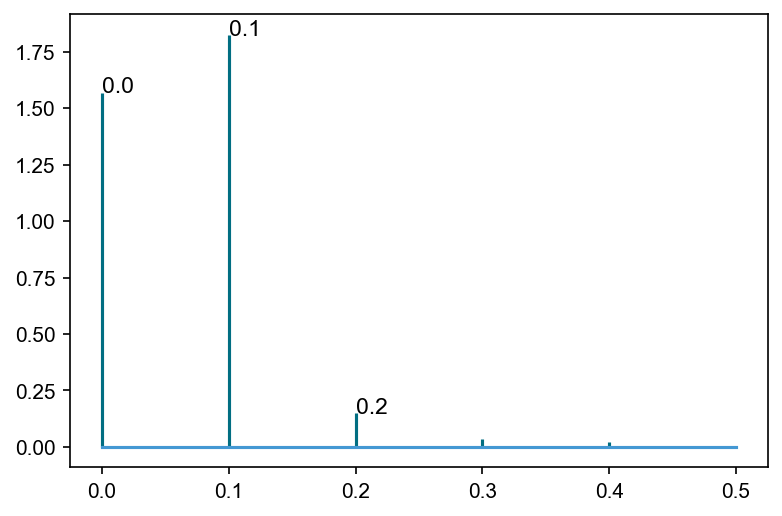

In [5]:
#the pulse for minimum total_error among iterations
best_controls=result1.best_controls
from numpy.fft import rfft,rfftfreq
import matplotlib.pyplot as plt
freq = rfftfreq(len(times), times[1]-times[0])
fourier = np.abs(rfft(best_controls[0]))
freq = rfftfreq(len(times), times[1]-times[0])
max_index = np.argpartition(abs(fourier), -3)[-3:]
fig,ax=plt.subplots()
ax.stem(freq, fourier, markerfmt=' ', label='')
for index in max_index:
    ax.annotate('{}'.format(freq[index]), xy=(freq[index], fourier[index]))

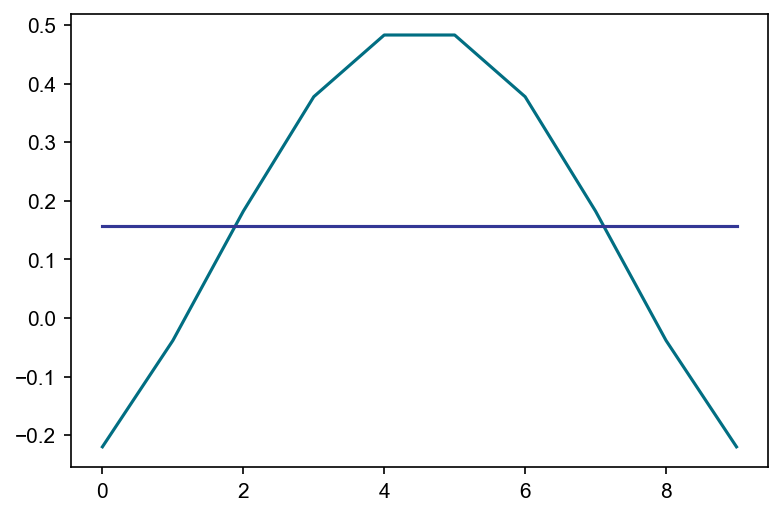

In [14]:
plt.plot(best_controls[0])
plt.plot(initial_control[0])

In [26]:
grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1,
                                optimizer=Adam(),initial_controls=best_controls,mode="AD")

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  1    | 2.60397484e-07 |  2.60397484e-07  |  0.00000000e+00  |  3.22736682e-03  


In [31]:
#detunning
H0=np.array([[1,0],[0,-1]])*((0.01)*2*np.pi/2)

In [32]:
#using robust pulse
grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1,
                                optimizer=Adam(),initial_controls=best_controls,mode="AD")

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  1    | 3.40791795e-03 |  1.08828894e-04  |  3.29908906e-03  |  1.06248140e+00  


In [33]:
#using cos pulse
grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1,
                                optimizer=Adam(),initial_controls=initial_control,mode="AD")

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  1    | 6.56721742e-01 |  3.93914734e-02  |  6.17330269e-01  |  1.36242611e+00  


In [37]:
H0=0
import qutip as qt
fluc=np.linspace(-10,10,101)*np.pi*1e-3
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
for i in range(len(fluc)):
    resolution=200
    qt_H0=qt.Qobj(H0+fluc[i]*np.array([[-1,0],[1,0]]))
    qt_Hc1=qt.Qobj(H_controls[0])
    qt_is=qt.Qobj(initial_states)
    qt_N=10
    qt_t=total_time
    qt_tlist=np.linspace(0,qt_t,qt_N*resolution)
    qt_c1 = np.array([])
    for value in initial_control[0]: 
        for j in range(resolution):
             qt_c1 = np.append(qt_c1,value)
    qt_H=[qt_H0,[qt_Hc1,qt_c1]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities[i]=1-max(result.expect[0])
    
    qt_c1 = np.array([])
    for value in best_controls[0]: 
        for j in range(resolution):
             qt_c1 = np.append(qt_c1,value)
    qt_H=[qt_H0,[qt_Hc1,qt_c1]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities_robust[i]=1-max(result.expect[0])


In [8]:
import qutip as qt

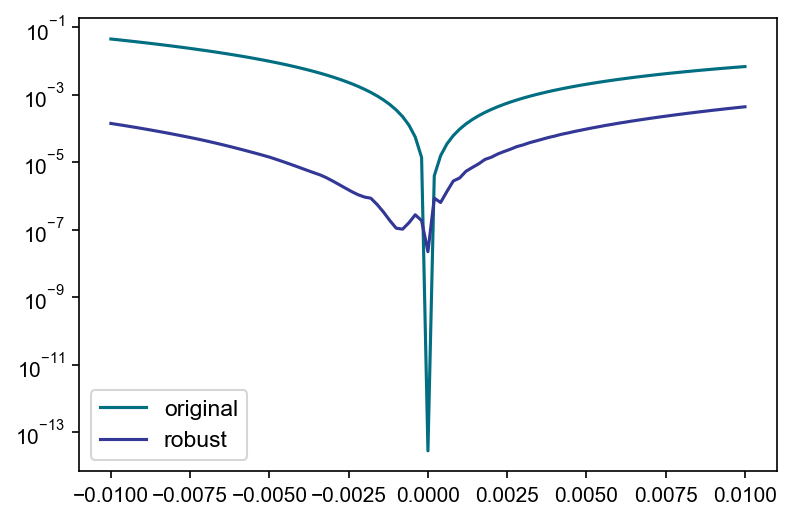

In [38]:
fig,ax=plt.subplots()
ax.plot(fluc/np.pi,infidelities,label='original')
ax.plot(fluc/np.pi,infidelities_robust,label='robust')
ax.set_yscale('log')
ax.legend()

In [6]:
total_time_steps=400
resolution=int(total_time_steps/10)
envolope=np.array([])
for value in best_controls[0]: 
    for j in range(resolution):
        envolope = np.append(envolope,value)
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
best_total_control1=envolope*np.cos(times)

In [11]:
len(qt_tlist)

4000

In [17]:
fluc=np.linspace(-10,10,101)*np.pi*1e-3
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
for i in range(len(fluc)):
    resolution=10
    qt_H0=qt.Qobj(H0+fluc[i]*np.array([[-1,0],[1,0]]))
    qt_Hc1=qt.Qobj(H_controls[0])
    qt_is=qt.Qobj(initial_states)
    qt_N=total_time_steps
    qt_t=total_time
    qt_tlist=np.linspace(0,qt_t,qt_N*resolution)
    qt_c2 = np.array([])
    for values in initial_control[0]: 
        for j in range(resolution):
             qt_c2 = np.append(qt_c2,values)
    qt_H=[qt_H0,[qt_Hc1,qt_c2]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities[i]=1-max(result.expect[0])
    
    qt_c2 = np.array([])
    for value in best_total_control[0]: 
        for j in range(resolution):
             qt_c2 = np.append(qt_c2,value)
    qt_H=[qt_H0,[qt_Hc1,qt_c2]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities_robust[i]=1-max(result.expect[0])


TypeError: 'numpy.ndarray' object is not callable

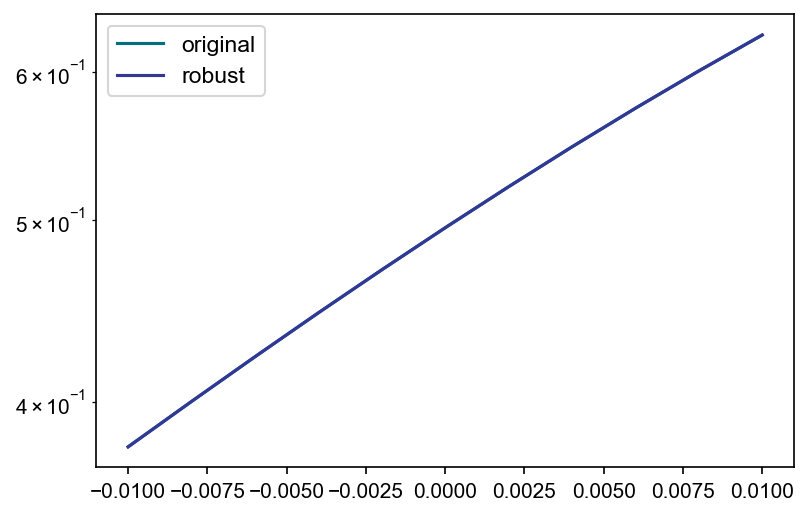

In [16]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots() 
ax.plot(fluc/np.pi,infidelities,label='original')
ax.plot(fluc/np.pi,infidelities_robust,label='robust')
ax.set_yscale('log')
ax.legend()